<h1><center> Machine Learning Classification models - the Heart dataset</center></h1>

### Outline

**i. Exploratory Data Analysis (EDA)**
- Statistic figure
- Imbalance dataset checking
- Relationship between features - Correlation matrix

**ii. Train and hyperparameters tuning**
- GNB, LDA, QDA

-  Hyperparameters tuning with Gridsearch
- LogReg, DecTree, Bagging, XGboost, RF, Adaboost, GraBoost

- Stacking

**iii.  Model comparision**
- Print test results and  boxplots of all models


## Detail Structure


### I. Exploratory Data Analysis (EDA)

Understand the data's properties and prepare it for modeling.

* **Setup:** Load necessary libraries and the dataset.
* **Data Overview:**
    * **Statistical Figures:** Display data types and descriptive statistics (mean, min, max, std)...
    * **Imbalance Dataset Check:** Visualize and quantify the class distribution (34%/66%).
* **Feature Relationships:**
    * **Correlation Matrix:** Calculate and visualize the correlation matrix between all features to check for multicollinearity.

---

### II. Training and Hyperparameter Tuning

Split the data and optimize our models using cross-validation.

* **Data Splitting:**
    * Split the data once: `X_train`, `X_test`, `y_train`, `y_test`.
    * Define **6-fold StratifiedKFold** for cross-validation (`cv`).
* **Baseline Models (No Tuning):**
    * Train and evaluate: **GNB, LDA, QDA**.
* **Hyperparameter Tuning (GridSearchCV):**
    * Use **GridSearchCV** with $\text{scoring} = \text{'recall'}$ for optimization.
    * Tune: **LogReg, DecTree, Bagging, XGBoost, RF, AdaBoost, GraBoost**.
* **Stacking Ensemble:**
    * Define `base_learners`: GNB, LDA, QDA
    * Define `meta_learner`: LogReg

---

### III. Model Comparison and Reporting

Visualize results and select the best model.

* **Final Evaluation:**
    * Define the `get_metrics` function to run $\text{cross_validate}$ on $\text{X}_{\text{train}}$ and then fit/predict on $\text{X}_{\text{test}}$. for all models
* **Reporting:**
    * Print the **Final Test Results Table**, sorted by **CV Recall** (highest priority metric).
* **Visualization:**
    * Generate two separate, large box plots:
        * **F2 Score:** Train vs. Test scores from CV folds.
        * **Recall:** Train vs. Test scores from CV folds.

# i. EDA

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate, cross_val_predict,
    StratifiedKFold, GridSearchCV, ParameterGrid
)
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, RocCurveDisplay, fbeta_score, make_scorer, auc,
    average_precision_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
from xgboost import XGBClassifier


In [3]:
tab = pd.read_csv("SAheart.txt")
tab = tab.drop(columns=['row.names','famhist']) #we do not use this feature
tab.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1


**Characteristics of eight features and target chd:**

sbp: systolic blood pressure\
tobacco: cumulative tobacco (kg)\
ldl: low density lipoprotein cholesterol\
adiposity\
typea: type-A behavior\
obesity\
alcohol: current alcohol consumption\
age: age at onset\
chd: coronary heart disease (yes=1 or no=0)

In [4]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   typea      462 non-null    int64  
 5   obesity    462 non-null    float64
 6   alcohol    462 non-null    float64
 7   age        462 non-null    int64  
 8   chd        462 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 32.6 KB


In [5]:
tab.describe().round(1)

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.0,462.0,462.0,462.0,462.0,462.0,462.0,462.0,462.0
mean,138.3,3.6,4.7,25.4,53.1,26.0,17.0,42.8,0.3
std,20.5,4.6,2.1,7.8,9.8,4.2,24.5,14.6,0.5
min,101.0,0.0,1.0,6.7,13.0,14.7,0.0,15.0,0.0
25%,124.0,0.1,3.3,19.8,47.0,23.0,0.5,31.0,0.0
50%,134.0,2.0,4.3,26.1,53.0,25.8,7.5,45.0,0.0
75%,148.0,5.5,5.8,31.2,60.0,28.5,23.9,55.0,1.0
max,218.0,31.2,15.3,42.5,78.0,46.6,147.2,64.0,1.0


**We will use classification models to predict the target 'chd' (binary) with 8 features**

In [6]:
## Input and Output
y=tab["chd"]
X = tab.drop(columns=['chd'])
# Imbalance checking
y.value_counts(normalize=True) #normalize to get percentage figure  

0    0.65368
1    0.34632
Name: chd, dtype: float64

34% -> mild imbalance
coronary heart disease (yes=1 or no=0), 34% data y= 1

In [7]:
# Y.value_counts().plot(kind='bar', figsize=(3,2))

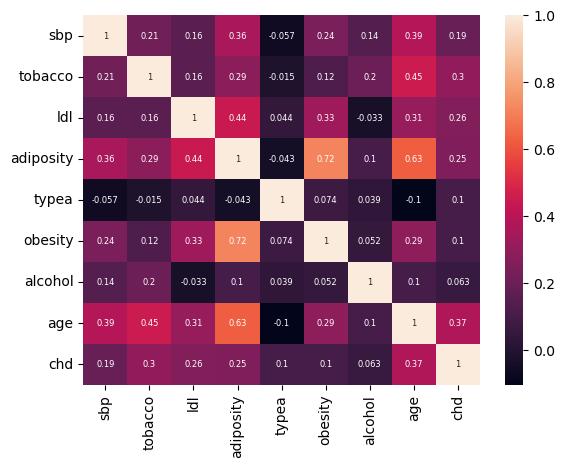

In [8]:
#Correlation Matrix
corr_matrix = tab.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 6})
plt.show()

### **Correlation comment**

**Predictor vs. Target:** The "worst" value is approx 0 because it means the predictor is useless for the model

**Predictor vs. Predictor:** The threshold for a **problematic correlation (multicollinearity) is typically |r| > 0.7 or 0.8**

- Corr (Adiposity, Obesity)~ 0.72 very strong positive correlation, which is expected as both relate to body fat/mass.
- Corr (Adiposity, Age) ~ 0.63 also show a strong positive correlation 

- The high correlation between adiposity and obesity suggests that including both in a multivariate model (like regression) might cause multicollinearity

- Here **VIF = 1/(1-r_squared) ~ 2 < 5--> moderate multicollinearity**, might be acceptable depending on the context


### **Issue: Mild imbalance data**

**Solution:** 
- Can use Undersampling or Oversampling

But, better solutions:
- Use class weight: Some models like Logistic Regression, SVM, and XGBoost.. (e.g. LogisticRegression(class_weight='balanced'))—easy, no data change.
    
- Ensemble methods
- Use other metrics other than Accuracy
- Combine methods if needed.   

In heart disease prediction (SAheart dataset, chd=1),**missing a real disease case (a False Negative) is more costly than classifying a non-disease person incorrectly (a False Positive).**

**Prioritize high sensitivity/recall, F2 - score (beta=2) over precision**

Recall (Sensitivity): This directly measures the proportion of actual disease cases we correctly classified. $\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$. Maximizing this minimizes $\text{FN}$

F2-score ($\beta=2$): This metric explicitly gives more weight to Recall than to Precision.Using $\beta=2$ (F2-score) is ideal because it aligns with the fatct that $\text{FN}$ are more costly than $\text{FP}$.
$$\text{F}_\beta = (1+\beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}$$

PR AUC (Area Under the Precision-Recall Curve): Unlike ROC AUC, the PR curve focuses entirely on the positive class and is much more sensitive to model performance in imbalanced datasets.

**Ensemble methods and Recall , F2-score (also F1 score, PR AUC, Precision) are used in this project**

In [1]:
#Confusion matrix 

from IPython.display import Image
Image(url='confusion matrix.jpg')

# ii. Train

In [9]:
#ML work flow
#source: #https://scikit-learn.org/stable/modules/cross_validation.html

Image(url='mlworkflow.jpg')

In [10]:
#Cross validation  is used for Model selection, hyperparameter tuning. 
#cv = 5 or 10 is commonly used, but we choose 6 to avoid heavy runs for tunned models and stacking. no of obs 462 

## Model Evaluation Concepts

**CV Tuning** evaluates param combos on folds/subsets of X_train/y_train
**Refit** (default refit=True) Retrains best_estimator_ with top params on full X_train/y_train post-tuning

---

## Key Metrics for FN Minimization

For critical classification where **False Negatives (FN) are highly costly**, the following metrics are prioritized:

* **Recall (Sensitivity):** **critical metric**. It directly measures the proportion of all actual positive cases correctly identified (minimizing FN).
    * **For Selection:** Use **Cross-Validated Recall** when comparing models to choose the best one.
    * **For Reporting:** Use the **Final Test Set Recall** to report the unbiased performance on truly unseen data.
* **F2-score:** Places Recall (4x) over Precision, perfectly aligning with the objective of more weight on FN.
---

##  Baseline and Diagnostic Metrics

* **F1-score:** Provides a baseline measure that equally balances Precision and Recall.
* **Precision:** Used as a diagnostic check to monitor False Positives (FP), though minimizing FN (via Recall/F2) remains the priority.

In [11]:
# 1 Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1/3, random_state=42)
#stratified sampling: ensure the proportion of obs for each class in y: same in y_train y_test. vital for imbalance dataset

# 2 CV and scorers
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42) 
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'f2': make_scorer(fbeta_score, beta=2),
    'prauc': 'average_precision'
}
# 3 Base models
base_models = {
    'GNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}
# 4 Decision Tree filtered params
param_grid = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 31),
    'min_samples_split': range(2, 41)
}
# Filter valid combinations
#conditions: min_samples_split >= 2 * min_samples_leaf

filtered_params_dt = [
    {'max_depth': [p['max_depth']],
     'min_samples_leaf': [p['min_samples_leaf']],
     'min_samples_split': [p['min_samples_split']]}
    for p in ParameterGrid(param_grid)
    if p['min_samples_split'] >= 2 * p['min_samples_leaf']
]
# 5 Tunable models
'''DT as Base learner model for Bagging: should be a deep and unpruned tree
      (a tree that is allowed to grow to its maximum complexity'''
param_grids = {
    'LogReg': (LogisticRegression(solver='liblinear', random_state=42), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), filtered_params_dt),
    'Bagging': (BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), {'n_estimators': [10, 50, 100]
                                                                                , 'max_samples': [0.6, 0.8, 1.0]}),
    'RandomForest': (RandomForestClassifier(random_state=42), {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, None]}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.2]}),
    'GradBoost': (GradientBoostingClassifier(random_state=42), {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.2]}),
    'XGBoost': (XGBClassifier(eval_metric='logloss', random_state=42),
    {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]})
}
# 6 Tune tunable models
tuned_models = {}
for name, (model, params) in param_grids.items():
    grid = GridSearchCV(model, params, scoring='recall', cv=cv, n_jobs=-1) # Optimizing for Recall (minimizing False Negatives)
    grid.fit(X_train, y_train)
    print(f"{name} Optimal Hyperparameters: {grid.best_params_}")
    tuned_models[name] = grid.best_estimator_
# All models
all_models = {**base_models, **tuned_models}

# 7 Define stacking classifier
base_learners = [
    ('gnb', all_models['GNB']),
    ('lda', all_models['LDA']),
    ('qda', all_models['QDA']),
    ('dt', all_models['DecisionTree']),
    ('logreg', all_models['LogReg'])
]
meta_learner = all_models['LogReg']  # Use tuned LogReg as meta-learner
stack = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=cv, n_jobs=-1)
all_models['Stacking'] = stack  # Add to all_models for unified evaluation


LogReg Optimal Hyperparameters: {'C': 0.1}
DecisionTree Optimal Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}
Bagging Optimal Hyperparameters: {'max_samples': 0.6, 'n_estimators': 50}
RandomForest Optimal Hyperparameters: {'max_depth': None, 'n_estimators': 200}
AdaBoost Optimal Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 100}
GradBoost Optimal Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 500}
XGBoost Optimal Hyperparameters: {'learning_rate': 0.05, 'n_estimators': 200}


## Stacking Base Learner Selection

We chose **GNB, LDA, QDA, Decision Tree, and LogReg** as base learners for stacking.

The two key rules for choosing any base learner for stacking are:

1.  **Diversity (Most Important):** The model must make **different types of errors** than the other models in the stack.
2.  **Performance:** The model must perform **significantly better than random chance** on the task. Its performance should also be competitive compared to the other base learners.

### Building the Stack

* It's a good idea to include a **mix of model types** (e.g., linear models like LogReg, non-linear models like GNB, and ensemble trees like Random Forest or XGBoost) to maximize diversity.
* We can include more ensemble models like **Bagging** and **XGBoost** in the stack, but be careful not to use too many similar tree-based ensembles. 

**Code Update:** Add ensemble models 

In [15]:
# adjust the code for adding models in stacking. uncomment the code 


# 7 Define stacking classifier
# base_learners = [
#     ('gnb', all_models['GNB']),
#     ('lda', all_models['LDA']),
#     ('qda', all_models['QDA']),
#     ('dt', all_models['DecisionTree']),
#     ('logreg', all_models['LogReg']),
#     ('bagging', all_models['Bagging']),
#     ('xgb', all_models['XGBoost']) 
# ]

# meta_learner = all_models['LogReg']
# stack = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=cv, n_jobs=-1)
# all_models['Stacking'] = stack 

# iii. Model comparision

In [12]:
# 8 Evaluate models

def get_metrics(model, X_train, y_train, X_test, y_test, cv, scoring):
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return {
        'CV Recall': np.mean(cv_res['test_recall']),
        'CV F2': np.mean(cv_res['test_f2']),
        'CV F1': np.mean(cv_res['test_f1']),
        'CV Precision': np.mean(cv_res['test_precision']),
        'CV PR AUC': np.mean(cv_res['test_prauc']),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F2': fbeta_score(y_test, y_pred, beta=2),
        'Test F1': f1_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test PR AUC': average_precision_score(y_test, y_prob)
    }
  
final_results = []
for name, model in all_models.items():
    metrics = get_metrics(model, X_train, y_train, X_test, y_test, cv, scoring)
    final_results.append({'Model': name, **metrics})
    
#  Final evaluation report (sorted by CV Recall)
df_results = pd.DataFrame(final_results).sort_values("CV Recall", ascending=False).reset_index(drop=True)
print(df_results.round(4))


           Model  CV Recall   CV F2   CV F1  CV Precision  CV PR AUC  \
0            GNB     0.5779  0.5751  0.5729        0.5744     0.6003   
1   DecisionTree     0.5229  0.5190  0.5168        0.5247     0.4874   
2            QDA     0.4586  0.4675  0.4864        0.5426     0.5565   
3        Bagging     0.4303  0.4470  0.4818        0.5966     0.5548   
4        XGBoost     0.4025  0.4183  0.4482        0.5286     0.5171   
5      GradBoost     0.4020  0.4073  0.4195        0.4593     0.4929   
6            LDA     0.3927  0.4141  0.4542        0.5607     0.5655   
7         LogReg     0.3927  0.4173  0.4625        0.5743     0.5250   
8       AdaBoost     0.3834  0.4045  0.4443        0.5498     0.5869   
9   RandomForest     0.3660  0.3820  0.4149        0.5235     0.5729   
10      Stacking     0.2631  0.2826  0.3260        0.6388     0.5788   

    Test Recall  Test F2  Test F1  Test Precision  Test PR AUC  
0        0.6226   0.6089   0.5893          0.5593       0.5759  
1    

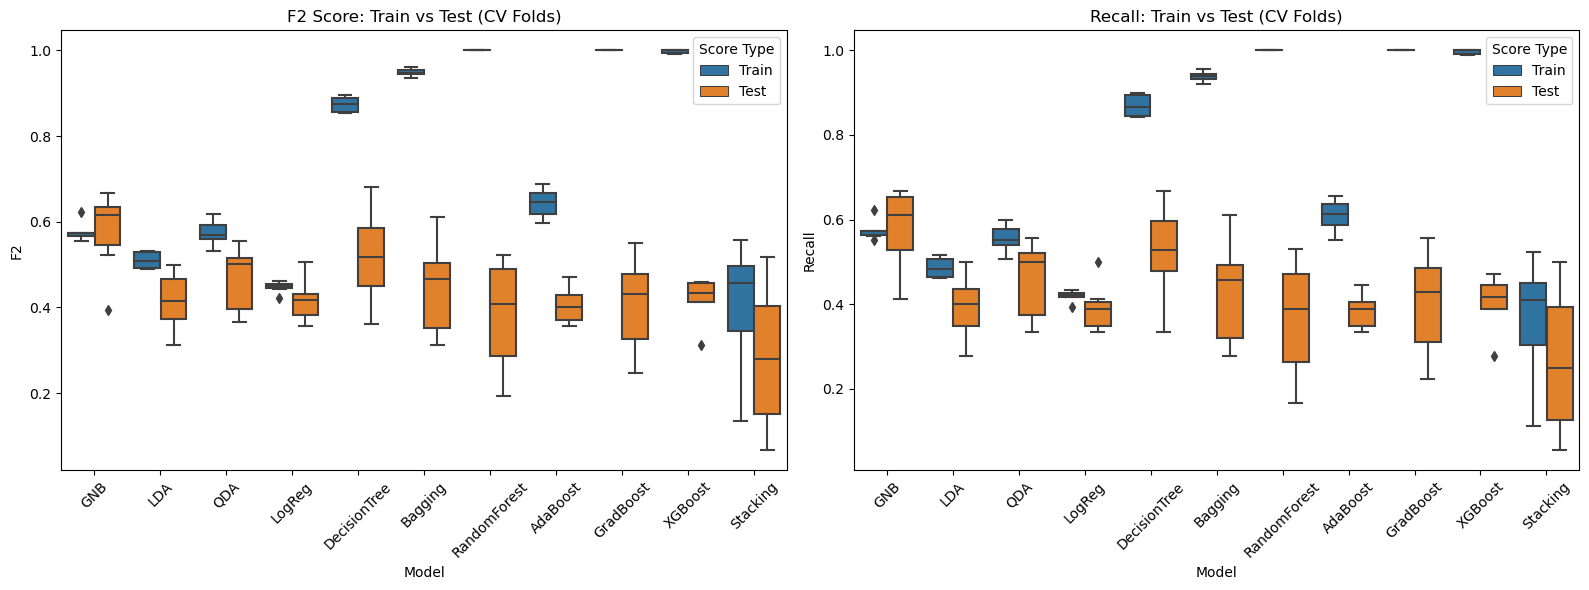

In [13]:
# 9  Boxplots: F2 and Recall (Train vs Test from CV folds on X_train)

plot_data_f2 = []
plot_data_recall = []
cv_scoring = {'f2': scoring['f2'], 'recall': scoring['recall']}
for name, model in all_models.items():
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=cv_scoring, return_train_score=True, n_jobs=-1)
    for tr_f2, te_f2, tr_rec, te_rec in zip(cv_res['train_f2'], cv_res['test_f2'], cv_res['train_recall'], cv_res['test_recall']):
        plot_data_f2.append({'Model': name, 'Score Type': 'Train', 'F2': tr_f2})
        plot_data_f2.append({'Model': name, 'Score Type': 'Test', 'F2': te_f2})
        plot_data_recall.append({'Model': name, 'Score Type': 'Train', 'Recall': tr_rec})
        plot_data_recall.append({'Model': name, 'Score Type': 'Test', 'Recall': te_rec})
df_f2 = pd.DataFrame(plot_data_f2)
df_recall = pd.DataFrame(plot_data_recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df_f2, x='Model', y='F2', hue='Score Type', ax=ax1)
ax1.set_title('F2 Score: Train vs Test (CV Folds)')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(data=df_recall, x='Model', y='Recall', hue='Score Type', ax=ax2)
ax2.set_title('Recall: Train vs Test (CV Folds)')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



## Box Plot Analysis
---

### Overfitting and Model Stability

* **High Overfitting:** The ensemble models (DecisionTree, Bagging, RandomForest, AdaBoost, GradBoost, and XGBoost) show **high variance** and significant **overfitting**, as their training scores (blue boxes) are dramatically higher than their test scores (orange boxes).
* **Low Overfitting:** The simple models (GNB, LDA, and LogReg) exhibit a much **smaller generalization gap**, indicating greater stability.
* **Poor Performance:** **Stacking** performs poorly, showing wide variance and low median test scores, suggesting the meta-learner failed to effectively combine the base predictions.

---

### GNB Performance and Outliers

* **Top Performer:** GNB is the **most stable and effective** classifier. It has the highest median Test F2 Score ($\approx 0.60$) and the tightest box plot (low variance).
* **Outliers:** The individual dots (outliers) in GNB indicate that its performance was highly sensitive to the data split in two specific CV folds. It achieved one exceptionally high score ($\approx 0.65$) on a "clean" training subset and one unusually poor score ($\approx 0.40$) on a "difficult" testing subset. This highlights GNB's susceptibility when its assumption of feature independence is severely violated by specific data partitions.

---

### Conclusion

Based on its superior performance and stability (low variance), **GNB** is the chosen model for this dataset.

* **Final Metrics:** (If focusing on Recall, which is FN-critical) GNB achieved a strong Mean Test CV Recall of **0.5779** and a Final Test Recall of **0.6226**.